In [45]:
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import torch.utils.data
import cv2
import torchvision.models.segmentation
import torch
import os
import albumentations as A

In [29]:
from torch.utils.data import Dataset
from PIL import Image
import scipy.io as sio
from torchvision.transforms.functional import to_tensor,to_pil_image
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pylab as plt

In [30]:
!cd vision && git checkout v0.3.0
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

error: Your local changes to the following files would be overwritten by checkout:
	.circleci/build_docs/commit_docs.sh
	.circleci/regenerate.py
	.circleci/unittest/android/scripts/install_gradle.sh
	.circleci/unittest/ios/scripts/binary_ios_build.sh
	.circleci/unittest/linux/scripts/install.sh
	.circleci/unittest/linux/scripts/post_process.sh
	.circleci/unittest/linux/scripts/run-clang-format.py
	.circleci/unittest/linux/scripts/run_test.sh
	.circleci/unittest/linux/scripts/setup_env.sh
	android/gradlew
	ios/VisionTestApp/clean.sh
	ios/VisionTestApp/setup.sh
	ios/build_ios.sh
	packaging/build_cmake.sh
	packaging/build_conda.sh
	packaging/build_wheel.sh
	scripts/fbcode_to_main_sync.sh
Please commit your changes or stash them before you switch branches.
Aborting


In [31]:
from engine import train_one_epoch, evaluate
import utils

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
cd drive/MyDrive/

[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/MyDrive


**Visualizing image and its mask**

In [34]:
mask= sio.loadmat("Project/Cpm/cpm17/train/Labels/image_15")
img= Image.open("Project/Cpm/cpm17/train/Images/image_15.png").convert('RGB')
img=to_tensor(img)
mask=mask['inst_map']
overlay=Image.open("Project/Cpm/cpm17/train/Overlay/image_15.png")
overlay=to_tensor(overlay)

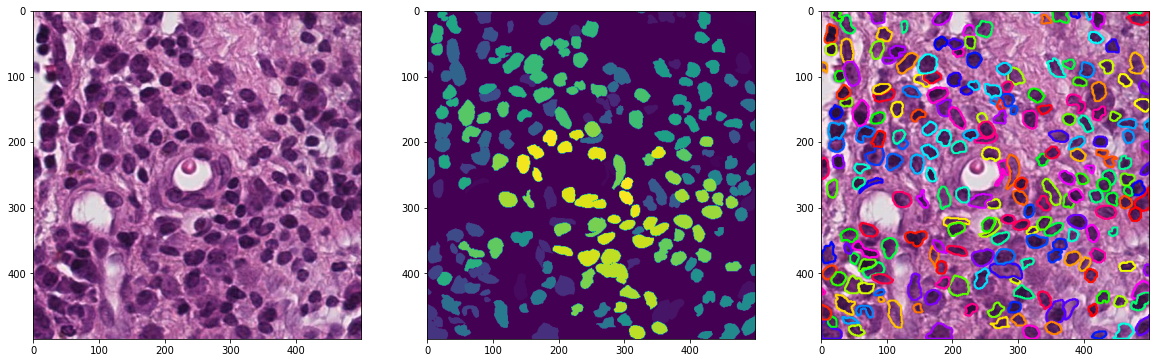

In [35]:
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(to_pil_image(img))
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.imshow(to_pil_image(overlay))

Specifying directories

In [36]:
TRAIN_IMG_DIR = "Project/Cpm/cpm17/train/Images"
TRAIN_LABEL_DIR = "Project/Cpm/cpm17/train/Labels"
TRAIN_MASK_DIR = "Project/Cpm/cpm17/train/Overlay"

TEST_IMG_DIR = "Project/Cpm/cpm17/test/Images"
TEST_LABEL_DIR = "Project/Cpm/cpm17/test/Labels"
TEST_MASK_DIR = "Project/Cpm/cpm17/test/Overlay"

**Custom Dataloader**

In [37]:
class Our_Dataset(Dataset):
    def __init__(self, image_dir,label_dir,mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.label_dir= label_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.masks=os.listdir(mask_dir)
        self.labels=os.listdir(label_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        label_path= os.path.join(self.label_dir, self.labels[index])
        img = Image.open(img_path).convert('RGB')
        mask_org = Image.open(mask_path)
        label= sio.loadmat(label_path)
        label = label["inst_map"]
        
        mask = np.array(label)
        mask_org=np.array(mask_org)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        img= to_tensor(img)
        mask= torch.from_numpy(mask_org).type(torch.long)
        # label = torch.as_tensor(label, dtype=torch.int64)
        label=torch.ones((num_objs,),dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["masks"] = mask


        return img,target

**Data Augmentation**

In [46]:
train_transform = A.Compose(
        [
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
        ],
    )

**Train Dataset**

In [47]:
train_ds=Our_Dataset(image_dir=TRAIN_IMG_DIR,label_dir=TRAIN_LABEL_DIR,mask_dir=TRAIN_MASK_DIR,transform=train_transform)
train_dl = DataLoader(train_ds, batch_size=2,num_workers=4, shuffle=True,collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Test Dataset**

In [39]:
test_ds=Our_Dataset(image_dir=TEST_IMG_DIR,label_dir=TEST_LABEL_DIR,mask_dir=TEST_MASK_DIR)
test_dl = DataLoader(test_ds, batch_size=2,num_workers=2, shuffle=True,collate_fn=utils.collate_fn)

**Model Mask RCNN**

In [13]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms.functional import convert_image_dtype

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [15]:
model=torchvision.models.detection.maskrcnn_resnet50_fpn()
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [16]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
num_epochs=10
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

**Training**

In [17]:
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=8)
   # update the learning rate
  lr_scheduler.step()
  # evaluate on the test dataset
  evaluate(model, test_dl, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/16]  eta: 0:00:38  lr: 0.000338  loss: 5.9334 (5.9334)  loss_classifier: 4.4972 (4.4972)  loss_box_reg: 0.1770 (0.1770)  loss_mask: 0.2187 (0.2187)  loss_objectness: 0.6924 (0.6924)  loss_rpn_box_reg: 0.3481 (0.3481)  time: 2.3792  data: 1.2694  max mem: 2061
Epoch: [0]  [ 8/16]  eta: 0:00:07  lr: 0.003002  loss: 5.7238 (66572451834.4124)  loss_classifier: 4.3685 (234885919.8341)  loss_box_reg: 0.3115 (45773340.6912)  loss_mask: -0.0308 (66282149195.1943)  loss_objectness: 0.6909 (3867571.2801)  loss_rpn_box_reg: 0.3481 (5776624.3017)  time: 0.8758  data: 0.1617  max mem: 2721
Loss is nan, stopping training
{'loss_classifier': tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(1.1822e+29, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(nan, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


**Transfer Learning**

In [40]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [41]:
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [42]:
# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# Construct a learning rate scheduler
# Learning rate scheduler decreases by 10x every 5 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=5,
                                            gamma=0.1)

In [43]:
num_classes = 2
model_2 = build_model(num_classes)
model.to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [44]:
train_one_epoch(model_2, optimizer, train_dl, device, epoch, print_freq=2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [0]  [ 0/16]  eta: 0:15:47  lr: 0.000338  loss: 11.6080 (11.6080)  loss_classifier: 0.6292 (0.6292)  loss_box_reg: 0.3308 (0.3308)  loss_mask: 2.4819 (2.4819)  loss_objectness: 7.7851 (7.7851)  loss_rpn_box_reg: 0.3809 (0.3809)  time: 59.1920  data: 2.9031
Epoch: [0]  [ 2/16]  eta: 0:11:33  lr: 0.001004  loss: 12.1066 (11.9639)  loss_classifier: 0.6292 (0.6250)  loss_box_reg: 0.3052 (0.2869)  loss_mask: 2.4819 (2.5424)  loss_objectness: 8.2852 (8.1537)  loss_rpn_box_reg: 0.3498 (0.3558)  time: 49.5449  data: 0.9679
Epoch: [0]  [ 4/16]  eta: 0:09:42  lr: 0.001670  loss: 12.1066 (12.1220)  loss_classifier: 0.6331 (0.6313)  loss_box_reg: 0.3284 (0.3299)  loss_mask: 2.4819 (2.5211)  loss_objectness: 8.2852 (8.2662)  loss_rpn_box_reg: 0.3809 (0.3734)  time: 48.5352  data: 0.5865
Epoch: [0]  [ 6/16]  eta: 0:07:53  lr: 0.002336  loss: 12.1066 (12.1615)  loss_classifier: 0.6292 (0.6185)  loss_box_reg: 0.3052 (0.3048)  loss_mask: 2.4914 (2.7032)  loss_objectness: 8.0395 (8.1429)  loss_rp

**Performance Measures**

Since helper function is used so I am finding it difficult to plot the graphs for these losses.